## Model interpretation 

### By using simplified syntetic air temperature data, the effects of the air temperature on soil temperature and soil moisture predictions can be analysed

In [1]:
import pandas as pd
from pandas import array

import numpy as np
import time
import math
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.dates

from numpy.lib import stride_tricks

from keras.models import Model
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, Concatenate, GRU, RepeatVector, TimeDistributed, Dropout, Concatenate, BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras import callbacks, layers

import tensorflow as tf

from scipy import signal

#from tensorflow import keras
#from tensorflow.keras import layers
print(np.version.version)
print(tf.__version__)

1.24.1
2.11.0


### Load soil temperature and soil moisture model

In [2]:
#new_model_m = tf.keras.models.load_model('') # fill in directory to soil moisture model

#new_model_t = tf.keras.models.load_model('') # fill in directory to soil temperature model

### Read data

In [3]:
windowSize=240

data_row = pd.read_csv("data_st_sm_11_years.csv")

at = np.squeeze(data_row["AirTempHourely"].to_numpy())
pr = np.squeeze(data_row["PrecHourely"].to_numpy()) #PrecHourely
st05 = np.squeeze(data_row["SoilTempHourely"].to_numpy()) 
st15 = np.squeeze(data_row["SoilTempHourely"].to_numpy()) 
st25 = np.squeeze(data_row["SoilTempHourely"].to_numpy()) 
sm05 = np.squeeze(data_row["SoilMoiHourely"].to_numpy()) #M_org
sm15 = np.squeeze(data_row["SoilMoiHourely"].to_numpy()) 
sm25 = np.squeeze(data_row["SoilMoiHourely"].to_numpy()) 

### Data normalisation

In [4]:
def create_norm_seq(seq,seq_norm_factor):
    seq_norm= (seq-np.min(seq_norm_factor))/(np.max(seq_norm_factor)-np.min(seq_norm_factor))
    return seq_norm

def create_re_norm_seq(seq,seq_norm_factor):
    re_norm_seq = ((seq*(max(seq_norm_factor)-min(seq_norm_factor)))+min(seq_norm_factor))#(seq-np.min(seq))/(np.max(seq)-np.min(seq))
    return re_norm_seq


### Function for model prediction

In [5]:

def predict_sequence_t(input_array_1,input_array_2):
    seqNum=np.floor(len(input_array_1)/windowSize)

    data2a = input_array_1[:int(seqNum)*windowSize]
    x1=np.split(data2a,seqNum)
    x1=np.stack(x1,axis=1)

    data2b = input_array_2[:int(seqNum)*windowSize]
    x2=np.split(data2b,seqNum)
    x2=np.stack(x2,axis=1)

    x1 = np.transpose(x1)
    x1 = x1.reshape(x1.shape[0],x1.shape[1],1)

    x2 = np.transpose(x2)
    x2 = x2.reshape(x2.shape[0],x2.shape[1],1)

    year_predict = new_model_t.predict([x1,x2],batch_size=1)

    year_predict = np.squeeze(year_predict)
    year_predict = year_predict.ravel()

    return year_predict

def predict_sequence_m(input_array_1,input_array_2):
    seqNum=np.floor(len(input_array_1)/windowSize)

    data2a = input_array_1[:int(seqNum)*windowSize]
    x1=np.split(data2a,seqNum)
    x1=np.stack(x1,axis=1)

    data2b = input_array_2[:int(seqNum)*windowSize]
    x2=np.split(data2b,seqNum)
    x2=np.stack(x2,axis=1)

    x1 = np.transpose(x1)
    x1 = x1.reshape(x1.shape[0],x1.shape[1],1)

    x2 = np.transpose(x2)
    x2 = x2.reshape(x2.shape[0],x2.shape[1],1)

    year_predict = new_model_m.predict([x1,x2],batch_size=1)

    year_predict = np.squeeze(year_predict)
    year_predict = year_predict.ravel()

    return year_predict


### Specifications of the simplified synthetic air temperature sequence

In [6]:
Fs = 2400 
f = 1/24
sample = 2400
period = 24/Fs
x = np.arange(sample)

x.shape

(2400,)

### Creation of simplified syntetic air temperature data by combining to harmonic sine waves and model prediction 

In [7]:
rain_zero = np.zeros(Fs)

index= np.arange(0,2400,1)
print(index)
print(index.shape)

temp_sine= 10+12.5*np.sin(24*2 * np.pi * f * x/Fs)+2.5*np.sin(Fs*2 * np.pi * f * x/Fs)
rain_zero = np.zeros(Fs)

temp_sine_norm = create_norm_seq(temp_sine,at)

soil_sine_norm_m = predict_sequence_m(temp_sine_norm,rain_zero)
soil_sine_norm_m = predict_sequence_m(temp_sine_norm,rain_zero)
soil_sine_norm_t = predict_sequence_t(temp_sine_norm,rain_zero)
soil_sine_norm_t = predict_sequence_t(temp_sine_norm,rain_zero)

soil_sine_m = create_re_norm_seq(soil_sine_norm_m,sm05)
soil_sine_t = create_re_norm_seq(soil_sine_norm_t,st05)

[   0    1    2 ... 2397 2398 2399]
(2400,)
10/10 [==============================] - 0s 15ms/step


### Creating plot for publication

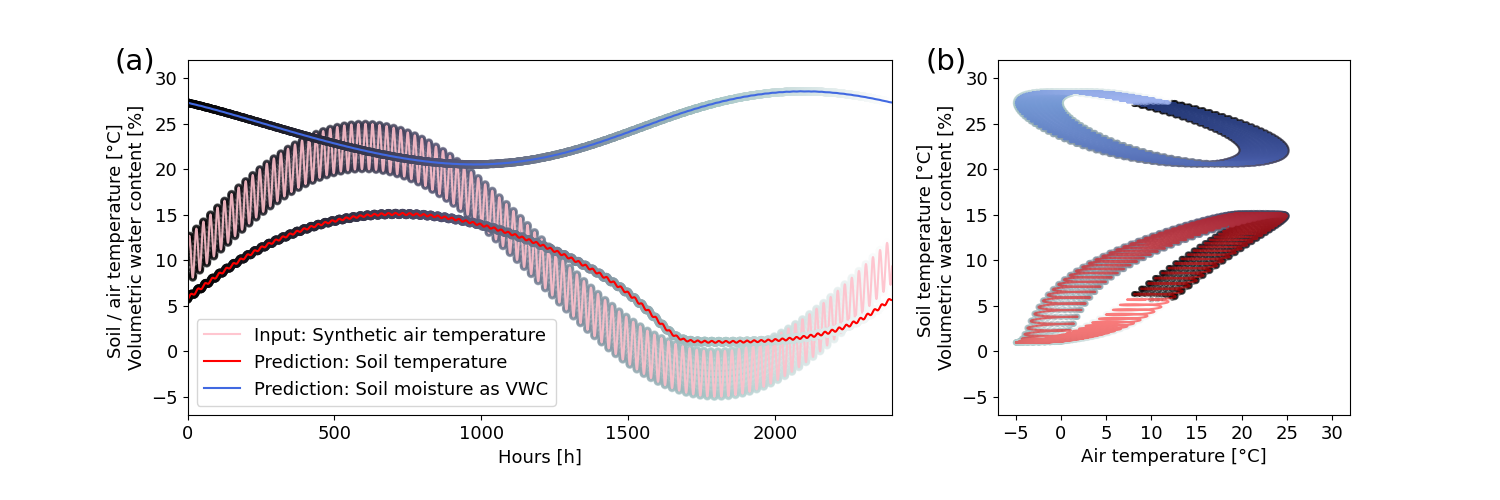

In [8]:
fig, ax = plt.subplots(1,2,figsize=(15,5),width_ratios=[2, 1])
fig.subplots_adjust(bottom=0.17,right=0.9,wspace=0.2)

ax[0].plot(temp_sine,label="Input: Synthetic air temperature",color="pink",alpha=0.9,zorder=1)
ax[0].scatter(index,temp_sine,c=index, cmap="bone",alpha=0.5,linewidth=0,zorder=0)
ax[0].plot(soil_sine_t,label="Prediction: Soil temperature",color="red")
ax[0].scatter(index,soil_sine_t,c=index, cmap="bone",alpha=0.5,linewidth=0)
ax[0].plot(soil_sine_m,label="Prediction: Soil moisture as VWC",color="royalblue")
ax[0].scatter(index,soil_sine_m,c=index, cmap="bone",alpha=0.5,linewidth=0)
ax[0].set_ylabel("Soil / air temperature [°C] \nVolumetric water content [%]",fontsize=13)
ax[0].tick_params(labelsize= 13)
ax[0].set_xlabel("Hours [h]",fontsize=13)
ax[0].set_ylim(-7,32)
ax[0].legend(prop={'size': 13})
ax[0].margins(x=0)

#ax[1].plot([-10,35], [-10, 35], ls="--", c=".3")
ax[1].scatter(temp_sine,soil_sine_t,c=index, cmap="bone",s=20,alpha=0.5,linewidth=0)
ax[1].plot(temp_sine,soil_sine_t,color="red",linewidth=1.5,alpha=0.5,label="Soil temperature")
ax[1].scatter(temp_sine,soil_sine_m,c=index, cmap="bone",s=20,alpha=0.5,linewidth=0)
ax[1].plot(temp_sine,soil_sine_m,color="royalblue",linewidth=1.5,alpha=0.5,label="Soil moisture")
ax[1].set_xlabel("Air temperature [°C]",fontsize=13)
ax[1].set_ylabel("Soil temperature [°C] \nVolumetric water content [%]",fontsize=13)
ax[1].set_xticks([-5,0,5,10,15,20,25,30],fontsize=13)
ax[1].set_yticks([-5,0,5,10,15,20,25,30],fontsize=13)
ax[1].tick_params(labelsize= 13)
ax[1].set_xlim(-7,32)
ax[1].set_ylim(-7,32)
#ax[1].set_yticklabels([])
ax[0].margins(x=0)

ax[0].text(-250, 31, "(a)", fontsize = 21)#weight='bold'
ax[1].text(-15, 31, "(b)", fontsize = 21)

plt.savefig('Fig4.pdf',bbox_inches='tight')
